# Read data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [2]:
# replace this with the file path on your computer
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)

In [3]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Null columns

In [4]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


In [5]:
# null_columns = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
#                 'FIRE_CODE', 'FIRE_NAME',
#                 'ICS_209_INCIDENT_NUMBER',  'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
#                 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
#                 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']

# we will not encode all of them, just encode these:
null_features = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
                         'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                         'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
                         'COUNTY', 'FIPS_CODE', 'FIPS_NAME']



There are five columns that are 99% null, from EDA section, we see that if they are not null, it will help with the prediction of some columns.  
For other features, it seems like encode them as null or not null both have benefits.

In [6]:
# fucntion that will encode this four columns
def null_encoding(df):
  # these columns will be encoded as 1 - null, 0 - not null
  for feature in null_features:
    df['NE-'+feature] = df[feature].isnull().astype(int)
  return df


Little note here: we tried to pass some columns with empty values to the model, since XGB is able to fill in te blank. However, the train error will be lower but the validation error is higher.

# Catagorical - Cross Entropy

We will try to use frequency encoding for every thing. Except for null columns and states.

In [7]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']
LC_features = ['FIRE_SIZE_CLASS',
                'NWCG_REPORTING_AGENCY',
                'OWNER_CODE', 'OWNER_DESCR',
                'SOURCE_SYSTEM', 'SOURCE_SYSTEM_TYPE']
catagorical_features = HC_features + LC_features

In [8]:
#  generic function for frequency encoding
from sklearn.preprocessing import LabelEncoder
frequency_encoder_map = {}
def train_frequency_encoders(df):
  for feature in catagorical_features:
    frequency_encoder = df[feature].value_counts(normalize=True)
    frequency_encoder_map[feature] = frequency_encoder
  return df

def frequency_encoding(df):
  for feature in catagorical_features:
    le = frequency_encoder_map[feature]
    df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
  return df

In [9]:
# train the frequency encoders
X_train = train_frequency_encoders(X_train)

# XGBoost

## Preparation

In [10]:
# select features for trainin: This list depends on feature engineering
encoded_catagorical_features = ['FE-' + feature for feature in catagorical_features]
encoded_null_features = ['NE-'+ feature for feature in null_features]
selected_features = encoded_catagorical_features + encoded_null_features

In [11]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(y)
def transform_y_for_XGB(y):
  return target_encoder.transform(y)

def transform_X_for_XGB(X):
  # frequency encoding
  X = frequency_encoding(X)

  # null encoding
  X = null_encoding(X)

  # select feature for training
  X = X[selected_features]
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})
  return X

# putting everything together so that it's easier
def transform_data_for_XGB(X, y):
  return transform_X_for_XGB(X), transform_y_for_XGB(y)

In [12]:
X_train, y_train = transform_data_for_XGB(X_train, y_train)
X_val, y_val = transform_data_for_XGB(X_val, y_val)

In [13]:
# save the files to drive, so that we can switch to GPU
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
dump_file(y_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
dump_file(X_val,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
dump_file(y_val, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
dump_file(target_encoder, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


## Training (Can switch to GPU)

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')


In [2]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    # "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": True,
    # "eval_metric": auc_ovr,
    #  "n_estimators": 2,
    # "max_cat_to_onehot": 4
    # "colsample_bylevel": 0.7,
    # 'objective':'multi:softmax',  # for multi-class classification
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:2.11813	validation_1-mlogloss:2.12041
[1]	validation_0-mlogloss:1.95452	validation_1-mlogloss:1.95748
[2]	validation_0-mlogloss:1.84782	validation_1-mlogloss:1.85108
[3]	validation_0-mlogloss:1.77516	validation_1-mlogloss:1.77918
[4]	validation_0-mlogloss:1.71868	validation_1-mlogloss:1.72299
[5]	validation_0-mlogloss:1.67753	validation_1-mlogloss:1.68222
[6]	validation_0-mlogloss:1.64412	validation_1-mlogloss:1.64919
[7]	validation_0-mlogloss:1.61659	validation_1-mlogloss:1.62218
[8]	validation_0-mlogloss:1.59585	validation_1-mlogloss:1.60188
[9]	validation_0-mlogloss:1.57890	validation_1-mlogloss:1.58519
[10]	validation_0-mlogloss:1.56428	validation_1-mlogloss:1.57090
[11]	validation_0-mlogloss:1.55272	validation_1-mlogloss:1.55971
[12]	validation_0-mlogloss:1.54312	validation_1-mlogloss:1.55039
[13]	validation_0-mlogloss:1.53486	validation_1-mlogloss:1.54229
[14]	validation_0-mlogloss:1.52730	validation_1-mlogloss:1.53498
[15]	validation_0-mlogloss:1.52145	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [3]:
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')


## Evaluation

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
target_encoder = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


In [2]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')

In [3]:
X_train

,FE-NWCG_REPORTING_UNIT_ID,FE-NWCG_REPORTING_UNIT_NAME,FE-SOURCE_REPORTING_UNIT,FE-SOURCE_REPORTING_UNIT_NAME,FE-FIRE_SIZE_CLASS,FE-NWCG_REPORTING_AGENCY,FE-OWNER_CODE,FE-OWNER_DESCR,FE-SOURCE_SYSTEM,FE-SOURCE_SYSTEM_TYPE,...,NE-MTBS_ID,NE-MTBS_FIRE_NAME,NE-COMPLEX_NAME,NE-DISCOVERY_TIME,NE-CONT_DATE,NE-CONT_DOY,NE-CONT_TIME,NE-COUNTY,NE-FIPS_CODE,NE-FIPS_NAME
371756,0.032985,0.032985,0.002740,0.002740,0.497544,0.723358,0.531671,0.531671,0.015738,0.721503,...,1,1,1,1,1,1,1,1,1,1
162848,0.016973,0.016973,0.005650,0.008330,0.358310,0.723358,0.172419,0.172419,0.374658,0.721503,...,1,1,1,0,0,0,0,0,0,0
279467,0.064920,0.064920,0.023535,0.024955,0.115701,0.723358,0.531671,0.531671,0.374658,0.721503,...,1,1,1,1,1,1,1,0,0,0
322716,0.043988,0.043988,0.000013,0.043988,0.497544,0.723358,0.531671,0.531671,0.374658,0.721503,...,1,1,1,0,0,0,0,0,0,0
108133,0.007263,0.007263,0.007263,0.007263,0.358310,0.723358,0.531671,0.531671,0.049385,0.721503,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.001593,0.001593,0.001593,0.001593,0.358310,0.723358,0.531671,0.531671,0.049385,0.721503,...,1,1,1,1,1,1,1,1,1,1
259178,0.004250,0.004250,0.004080,0.004080,0.358310,0.053313,0.172419,0.172419,0.136034,0.276485,...,1,1,1,0,0,0,0,0,0,0
365838,0.003918,0.003918,0.003918,0.003918,0.358310,0.053313,0.172419,0.172419,0.136034,0.276485,...,1,1,1,0,0,0,0,0,0,0
131932,0.046770,0.046770,0.001945,0.001945,0.497544,0.723358,0.531671,0.531671,0.026113,0.721503,...,1,1,1,1,1,1,1,0,0,0


In [4]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Each Class')
  plt.legend(loc='lower right')
  plt.show()

In [5]:
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8205859234136315

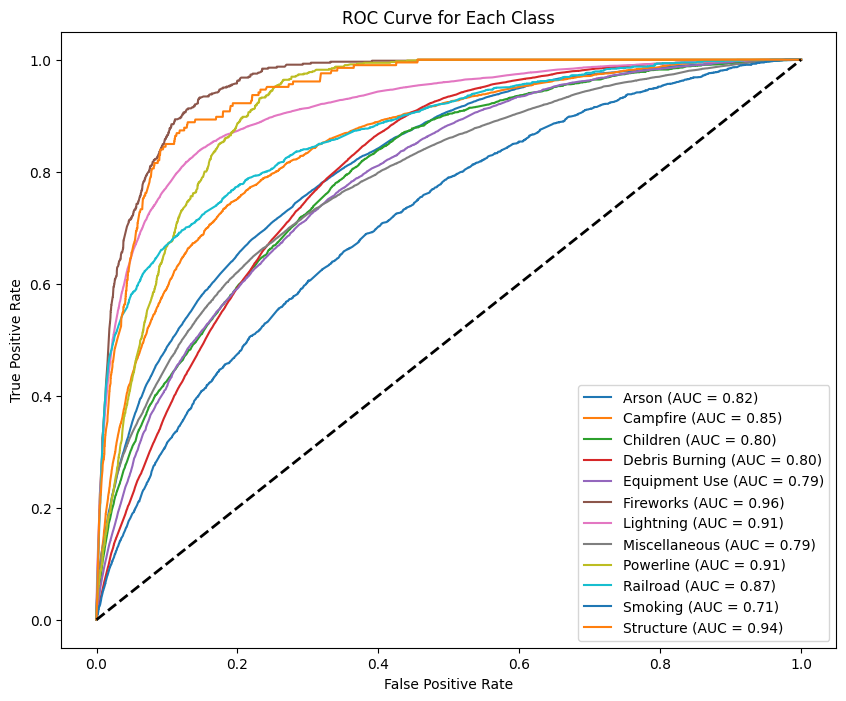

In [6]:
plot_auc_by_class(y_val, y_pred_prob)